# Projet Traitement de Signaux ECG - Détection d'Anomalies Semi-Supervisée
## Licence Informatique 3ème année
***
Ce notebook implémente un autoencodeur pour la détection semi-supervisée d'anomalies dans des signaux ECG.

## Imports et Configuration

In [ ]:
# -*- coding: utf-8 -*-
"""
Projet Traitement de Signaux ECG - Détection d'Anomalies Semi-Supervisée
Licence Informatique 3ème année
"""

# Imports nécessaires
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
import time # Pour la mesure du temps d'inférence

# Configuration et Paramètres (regroupés pour faciliter la modification)
DATA_FILE = 'ecg_dataset.mat'
RANDOM_STATE = 42 # Pour la reproductibilité
TEST_SPLIT_SIZE = 0.2 # Taille de l'ensemble de test initial (N, R, V)
VAL_SPLIT_SIZE = 0.2 # Taille de l'ensemble de validation (basé sur les données normales uniquement)
N_EPOCHS = 100
BATCH_SIZE = 64
THRESHOLD_STD_FACTOR = 3 # Nombre d'écarts-types pour le seuil
MODEL_SAVE_PATH = 'best_autoencoder.keras' # Chemin pour sauvegarder le meilleur modèle

# Fixer les graines pour la reproductibilité
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

## 1) Chargement et Prétraitement des Données
***
Chargement du fichier `.mat`, séparation des ensembles d'entraînement, de validation et de test, et normalisation des signaux.

In [ ]:
print("--- Chargement et Prétraitement des Données ---")

# Charger le fichier .mat
try:
    data = loadmat(DATA_FILE)
    X = data['X'] # Signaux ECG (N_samples, N_points)
    y = data['y'].flatten() # Classes (0=N, 1=R, 2=V)
    print(f"Données chargées: {X.shape[0]} signaux de {X.shape[1]} points.")
    print(f"Classes présentes: {np.unique(y)}")
except FileNotFoundError:
    print(f"Erreur: Le fichier '{DATA_FILE}' n'a pas été trouvé.")
    # Gérer l'erreur comme nécessaire, par exemple en arrêtant le script
    exit()
except KeyError as e:
    print(f"Erreur: Clé {e} non trouvée dans le fichier .mat. Vérifiez le contenu du fichier.")
    # Gérer l'erreur
    exit()

# Séparer l'ensemble de TEST (contenant N, R, V) avant toute autre chose
# Utilisation de stratify pour conserver les proportions des classes dans les ensembles
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=TEST_SPLIT_SIZE, random_state=RANDOM_STATE, stratify=y 
)
print(f"Taille de l'ensemble de test: {X_test.shape[0]} échantillons.")

# Isoler les données normales (N) pour l'entraînement/validation de l'autoencodeur
X_normal = X_temp[y_temp == 0]
y_normal = y_temp[y_temp == 0] # Non utilisé pour l'AE mais conservé

print(f"Nombre de signaux normaux pour entraînement/validation: {X_normal.shape[0]}")

# Fonction de Normalisation (Standardisation) CORRIGÉE
def normalize_signals(signals, scaler=None):
    """
    Normalise (standardise) les signaux ECG sur l'axe des features (temps).

    Args:
        signals (np.array): Tableau numpy de signaux (n_samples, n_points).
        scaler (StandardScaler, optional): Scaler pré-entraîné. Si None, un nouveau scaler est créé et ajusté.

    Returns:
        tuple: (signals_normalized, scaler)
               signals_normalized (np.array): Signaux normalisés.
               scaler (StandardScaler): Le scaler utilisé (nouveau ou celui fourni).
    """
    if scaler is None:
        scaler = StandardScaler()
        # Ajuster le scaler sur les features (colonnes = points temporels)
        # à travers les échantillons (lignes = signaux)
        signals_normalized = scaler.fit_transform(signals) # Suppression de .T ici
    else:
        # Transformer les nouveaux signaux en utilisant le scaler existant
        signals_normalized = scaler.transform(signals) # Suppression de .T ici
    return signals_normalized, scaler

# Normaliser les données normales (créer le scaler)
X_normal_normalized, scaler = normalize_signals(X_normal)

# Normaliser l'ensemble de TEST avec le MEME scaler entraîné sur les données normales
X_test_normalized, _ = normalize_signals(X_test, scaler=scaler)

# Diviser les données normales normalisées en ensembles d'entraînement et de validation
X_train_norm, X_val_norm, _, _ = train_test_split(
    X_normal_normalized, y_normal, # y_normal n'est pas utilisé ici mais requis par train_test_split
    test_size=VAL_SPLIT_SIZE,
    random_state=RANDOM_STATE
)

# Ajouter la dimension "canal" pour Keras (samples, timesteps, features)
X_train = X_train_norm[..., np.newaxis]
X_val = X_val_norm[..., np.newaxis]
X_test_keras = X_test_normalized[..., np.newaxis] # Pour les prédictions du modèle

print(f"Taille entraînement (normal): {X_train.shape}")
print(f"Taille validation (normal): {X_val.shape}")
print(f"Taille test (N, R, V): {X_test_keras.shape}")

--- Chargement et Prétraitement des Données ---
Données chargées: 5405 signaux de 146 points.
Classes présentes: [0 1 2]
Taille de l'ensemble de test: 1081 échantillons.
Nombre de signaux normaux pour entraînement/validation: 4230
Taille entraînement (normal): (3384, 146, 1)
Taille validation (normal): (846, 146, 1)
Taille test (N, R, V): (1081, 146, 1)


## 2) Définition du Modèle Autoencodeur
***
Définition de l'architecture de l'autoencodeur convolutionnel 1D avec Keras.

In [ ]:
print("\n--- Définition du Modèle ---")

def create_autoencoder(input_shape=(146, 1)):
    """
    Crée le modèle d'autoencodeur convolutionnel 1D.

    Args:
        input_shape (tuple): Dimension de l'entrée (longueur_sequence, canaux).

    Returns:
        keras.Model: Le modèle autoencodeur compilé.
    """
    inputs = layers.Input(shape=input_shape)

    # ----- ENCODEUR -----
    # Utilisation de 'padding=same' pour potentiellement simplifier le décodeur
    # Augmentation légère du Dropout
    x = layers.Conv1D(64, 7, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2, padding='same')(x)
    x = layers.Dropout(0.25)(x) # Légère augmentation

    x = layers.Conv1D(32, 7, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2, padding='same')(x)
    x = layers.Dropout(0.25)(x) # Légère augmentation

    x = layers.Conv1D(16, 7, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    encoded = layers.MaxPooling1D(2, padding='same', name="encoded")(x) # Forme: (None, 19, 16) si input=146

    # ----- DÉCODEUR -----
    x = layers.Conv1D(16, 7, activation='relu', padding='same')(encoded)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling1D(2)(x) # Forme: (None, 38, 16)

    x = layers.Conv1D(32, 7, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling1D(2)(x) # Forme: (None, 76, 32)

    x = layers.Conv1D(64, 7, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling1D(2)(x) # Forme: (None, 152, 64)

    # Couche finale pour reconstruire le canal unique
    decoded_padded = layers.Conv1D(1, 7, activation='linear', padding='same')(x) # Forme: (None, 152, 1)

    # Ajustement de la sortie à la taille initiale (146)
    # Calcule le cropping nécessaire: (152 - 146) = 6. Crop de 3 de chaque côté.
    cropping_needed = decoded_padded.shape[1] - input_shape[0]
    if cropping_needed > 0:
        crop_size = cropping_needed // 2
        # S'assurer que le cropping est symétrique, sinon ajuster
        if cropping_needed % 2 == 0:
             decoded = layers.Cropping1D((crop_size, crop_size))(decoded_padded)
        else:
             # Crop asymétrique si nécessaire (ex: 151 -> 146 => crop (2, 3))
             decoded = layers.Cropping1D((crop_size, crop_size + 1))(decoded_padded)
    elif cropping_needed < 0:
        # Si la sortie est plus courte, utiliser ZeroPadding (peu probable avec padding='same')
        padding_needed = -cropping_needed
        pad_size = padding_needed // 2
        if padding_needed % 2 == 0:
            decoded = layers.ZeroPadding1D((pad_size, pad_size))(decoded_padded)
        else:
            decoded = layers.ZeroPadding1D((pad_size, pad_size + 1))(decoded_padded)
    else:
        decoded = decoded_padded # Taille déjà correcte

    # Création du modèle
    autoencoder_model = Model(inputs, decoded)

    # Compilation
    autoencoder_model.compile(optimizer='adam', loss='mse')

    return autoencoder_model

# Créer le modèle
input_shape = X_train.shape[1:]
autoencoder = create_autoencoder(input_shape)
autoencoder.summary() # Affiche l'architecture


--- Définition du Modèle ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 146, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 146, 64)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 146, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 73, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 73, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 73, 32)         │        14,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 73, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 37, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 37, 16)         │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded (MaxPooling1D)          │ (None, 19, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 19, 16)         │         1,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 38, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 38, 32)         │         3,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 38, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 76, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 76, 64)         │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 76, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_2 (UpSampling1D)  │ (None, 152, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 152, 1)         │           44

 Total params: 39,649 (154.88 KB)

 Trainable params: 39,201 (153.13 KB)

 Non-trainable params: 448 (1.75 KB)

## 3) Entraînement du Modèle
***
Entraînement de l'autoencodeur sur les données normales, avec callbacks pour sauvegarder le meilleur modèle et arrêter prématurément.


--- Entraînement du Modèle ---
Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0988
Epoch 1: val_loss improved from None to 0.69023, saving model to best_autoencoder.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.6819 - val_loss: 0.6902
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2508
Epoch 2: val_loss improved from 0.69023 to 0.66821, saving model to best_autoencoder.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.2956 - val_loss: 0.6682
Epoch 3/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2131
Epoch 3: val_loss improved from 0.66821 to 0.61271, saving model to best_autoencoder.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2568 - val_loss: 0.6127
Epoch 4/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1920
Epoch 4: val_loss improved from 0.61271 to 0.55688, saving model to best_autoencoder.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2357 - val_loss: 0.5569
Epoch 5/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 

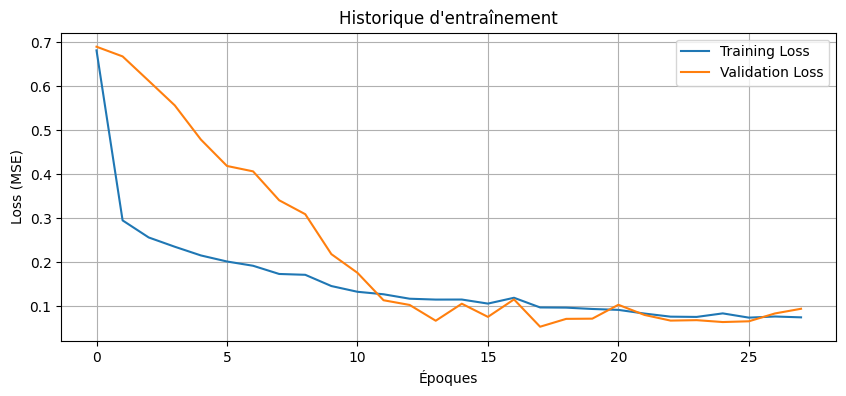


Chargement du meilleur modèle depuis: best_autoencoder.keras


In [ ]:
print("\n--- Entraînement du Modèle ---")

# Callbacks
checkpoint_cb = ModelCheckpoint(
    MODEL_SAVE_PATH, save_best_only=True, monitor='val_loss', mode='min', verbose=1
)
early_stopping_cb = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, mode='min', verbose=1 # Patience augmentée à 10
)

# Entraînement
history = autoencoder.fit(
    X_train, X_train, # Entrée = Sortie pour l'autoencodeur
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, X_val), # Utiliser X_val normalisé pour la validation
    callbacks=[checkpoint_cb, early_stopping_cb],
    verbose=1
)

# Optionnel: Visualiser l'historique d'entraînement
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Historique d\'entraînement')
plt.xlabel('Époques')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Charger le meilleur modèle sauvegardé (celui avec la meilleure val_loss)
print(f"\nChargement du meilleur modèle depuis: {MODEL_SAVE_PATH}")
if os.path.exists(MODEL_SAVE_PATH):
    best_autoencoder = keras.models.load_model(MODEL_SAVE_PATH)
else:
    print("Attention: Aucun modèle sauvegardé trouvé. Utilisation du dernier modèle entraîné.")
    best_autoencoder = autoencoder # Fallback au dernier modèle si la sauvegarde a échoué

## 4) Évaluation et Détection d'Anomalies
***
Calcul du seuil sur l'ensemble de validation, prédiction sur l'ensemble de test et visualisation de la distribution des erreurs.


--- Évaluation et Détection d'Anomalies ---
Prédiction sur l'ensemble de validation...
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Seuil de détection calculé sur l'ensemble de validation: 0.393746
Prédiction sur l'ensemble de test...
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


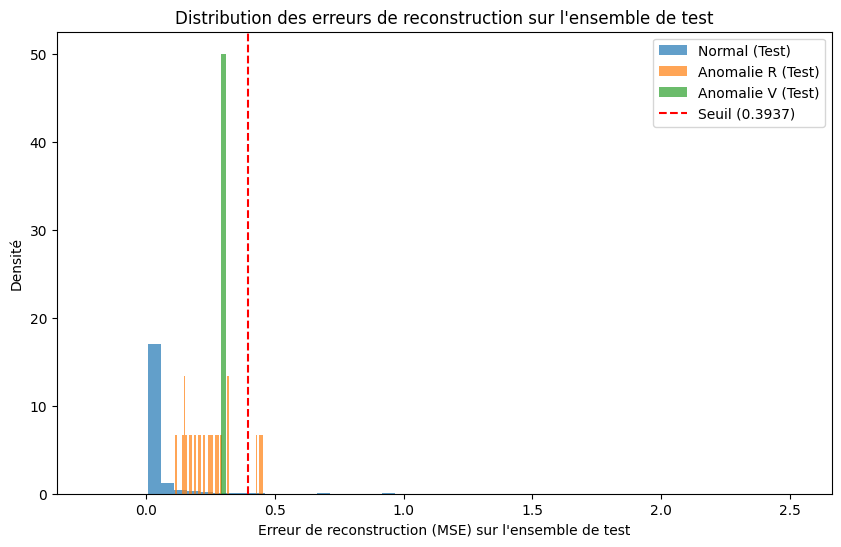

In [ ]:
print("\n--- Évaluation et Détection d'Anomalies ---")

# Prédictions sur l'ensemble de VALIDATION (pour déterminer/vérifier le seuil)
print("Prédiction sur l'ensemble de validation...")
reconstructions_val = best_autoencoder.predict(X_val)
reconstructions_val = reconstructions_val.squeeze() # Enlever la dim canal
mse_val = np.mean(np.square(X_val_norm - reconstructions_val), axis=1)

# Calcul du seuil basé sur la validation
threshold = np.mean(mse_val) + THRESHOLD_STD_FACTOR * np.std(mse_val)
print(f"Seuil de détection calculé sur l'ensemble de validation: {threshold:.6f}")

# Prédictions sur l'ensemble de TEST (N, R, V)
print("Prédiction sur l'ensemble de test...")
reconstructions_test = best_autoencoder.predict(X_test_keras)
reconstructions_test = reconstructions_test.squeeze() # Enlever la dim canal

# Calcul du MSE sur l'ensemble de test normalisé
mse_test = np.mean(np.square(X_test_normalized - reconstructions_test), axis=1)

# Visualisation des erreurs sur l'ensemble de test
plt.figure(figsize=(10, 6))
plt.hist(mse_test[y_test == 0], bins=50, alpha=0.7, label='Normal (Test)', density=True)
plt.hist(mse_test[y_test == 1], bins=50, alpha=0.7, label='Anomalie R (Test)', density=True)
plt.hist(mse_test[y_test == 2], bins=50, alpha=0.7, label='Anomalie V (Test)', density=True)
plt.axvline(threshold, color='r', linestyle='--', label=f'Seuil ({threshold:.4f})')
plt.xlabel("Erreur de reconstruction (MSE) sur l'ensemble de test")
plt.ylabel("Densité")
plt.title("Distribution des erreurs de reconstruction sur l'ensemble de test")
plt.legend()
plt.show()

# Classification basée sur le seuil
y_pred_anomaly = (mse_test > threshold).astype(int) # 0 = Normal, 1 = Anomalie (R ou V)
y_test_binary = (y_test > 0).astype(int) # 0 = Normal (N), 1 = Anomalie (R ou V)

## 5) Métriques de Performance
***
Calcul de la matrice de confusion, du rapport de classification, de l'AUC-ROC et analyse par classe d'anomalie sur l'ensemble de test.


--- Métriques de Performance (sur Ensemble de Test) ---
Matrice de Confusion (0=Normal, 1=Anomalie):
[[1038   20]
 [  20    3]]

Rapport de Classification (Normal vs Anomalie):
                precision    recall  f1-score   support

    Normal (N)       0.98      0.98      0.98      1058
Anomalie (R+V)       0.13      0.13      0.13        23

      accuracy                           0.96      1081
     macro avg       0.56      0.56      0.56      1081
  weighted avg       0.96      0.96      0.96      1081


AUC-ROC Score: 0.9602


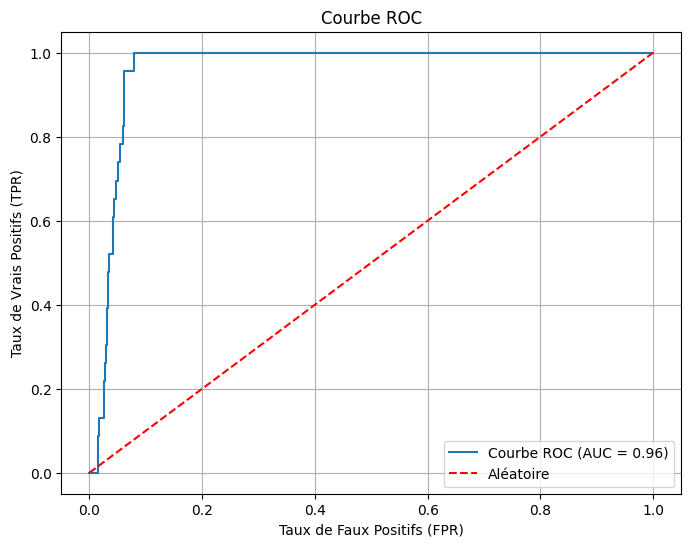


Analyse détaillée par classe réelle:
Anomalies R détectées: 3 / 22 (13.64% si r_total > 0 else 'N/A')
Anomalies V détectées: 0 / 1 (0.00% si v_total > 0 else 'N/A')
Faux Positifs (N détectés comme anormaux): 20 / 1058 (1.89% si n_total > 0 else 'N/A')


In [ ]:
print("\n--- Métriques de Performance (sur Ensemble de Test) ---")

# Matrice de confusion (Normal vs Anomalie)
print("Matrice de Confusion (0=Normal, 1=Anomalie):")
cm = confusion_matrix(y_test_binary, y_pred_anomaly)
print(cm)
# [[TN, FP],
#  [FN, TP]]

# Rapport de classification
print("\nRapport de Classification (Normal vs Anomalie):")
print(classification_report(y_test_binary, y_pred_anomaly, target_names=['Normal (N)', 'Anomalie (R+V)']))

# Calcul AUC-ROC si possible (si les deux classes sont présentes dans les prédictions)
try:
    auc = roc_auc_score(y_test_binary, mse_test) # Utiliser mse_test comme score
    print(f"\nAUC-ROC Score: {auc:.4f}")

    # Tracer la courbe ROC
    fpr, tpr, thresholds_roc = roc_curve(y_test_binary, mse_test)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Courbe ROC (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Aléatoire')
    plt.xlabel('Taux de Faux Positifs (FPR)')
    plt.ylabel('Taux de Vrais Positifs (TPR)')
    plt.title('Courbe ROC')
    plt.legend()
    plt.grid(True)
    plt.show()

except ValueError as e:
    print(f"\nImpossible de calculer l'AUC-ROC: {e}")


# Analyse plus fine par classe d'anomalie
print("\nAnalyse détaillée par classe réelle:")
# Anomalies R détectées / total R
r_detected = np.sum((y_test == 1) & (y_pred_anomaly == 1))
r_total = np.sum(y_test == 1)
print(f"Anomalies R détectées: {r_detected} / {r_total} ({r_detected/r_total:.2%} si r_total > 0 else 'N/A')")

# Anomalies V détectées / total V
v_detected = np.sum((y_test == 2) & (y_pred_anomaly == 1))
v_total = np.sum(y_test == 2)
print(f"Anomalies V détectées: {v_detected} / {v_total} ({v_detected/v_total:.2%} si v_total > 0 else 'N/A')")

# Faux positifs (N classés comme anomalies)
fp = np.sum((y_test == 0) & (y_pred_anomaly == 1))
n_total = np.sum(y_test == 0)
print(f"Faux Positifs (N détectés comme anormaux): {fp} / {n_total} ({fp/n_total:.2%} si n_total > 0 else 'N/A')")

## 6) Visualisation des Erreurs (Exemples)
***
Affichage d'exemples spécifiques de vrais/faux positifs et négatifs pour mieux comprendre le comportement du modèle.


--- Visualisation d'exemples ---
Exemple Vrai Négatif (Normal détecté Normal)


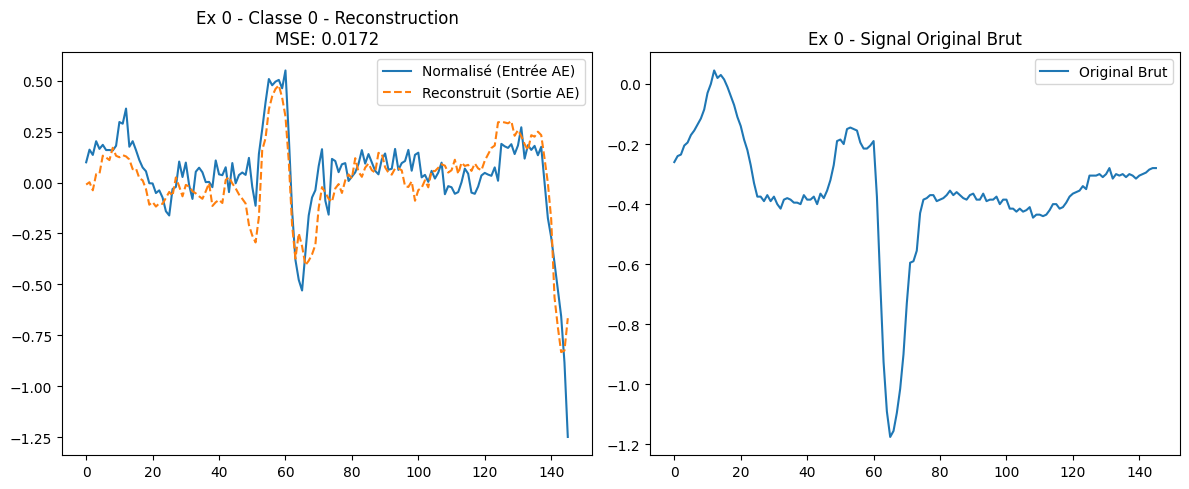

Prédiction: Normal | Réalité: Normal
-> VRAI NEGATIF
------------------------------
Exemple Faux Positif (Normal détecté Anomalie)


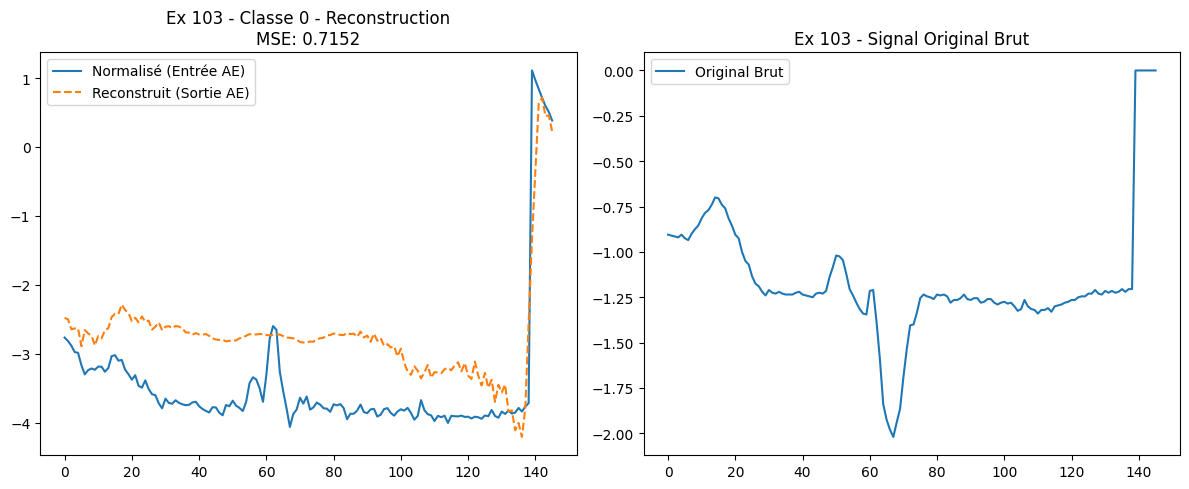

Prédiction: Anomalie | Réalité: Normal
-> FAUX POSITIF
------------------------------
Exemple Vrai Positif (Anomalie R détectée)


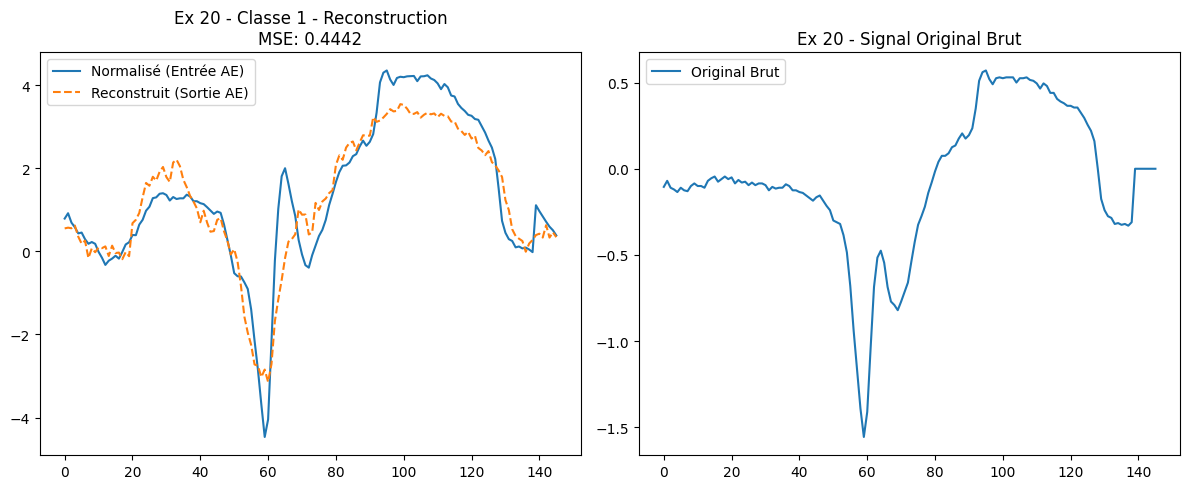

Prédiction: Anomalie | Réalité: Anomalie
-> VRAI POSITIF
------------------------------
Exemple Faux Négatif (Anomalie R détectée Normal)


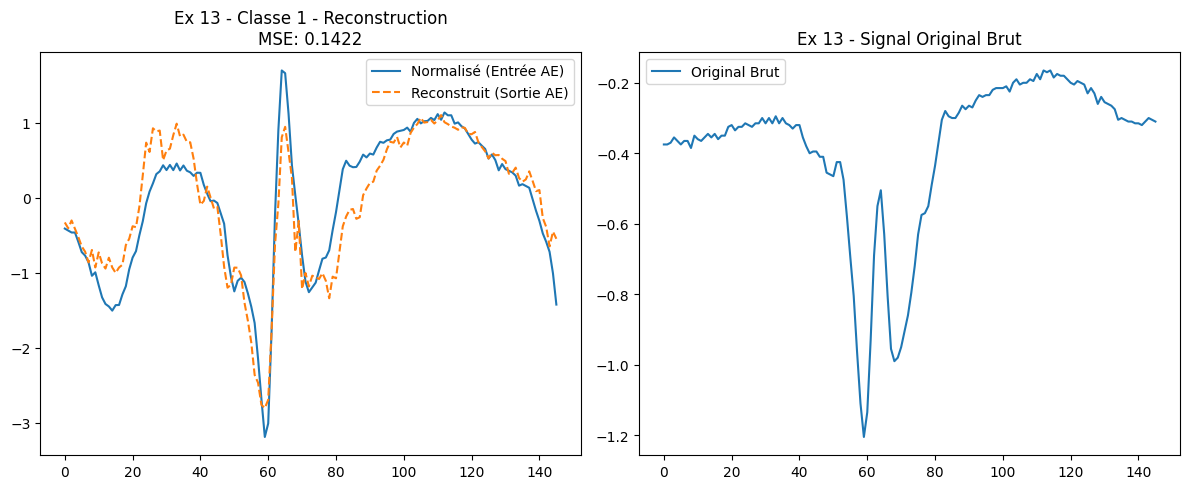

Prédiction: Normal | Réalité: Anomalie
-> FAUX NEGATIF
------------------------------
Exemple Faux Négatif (Anomalie V détectée Normal)


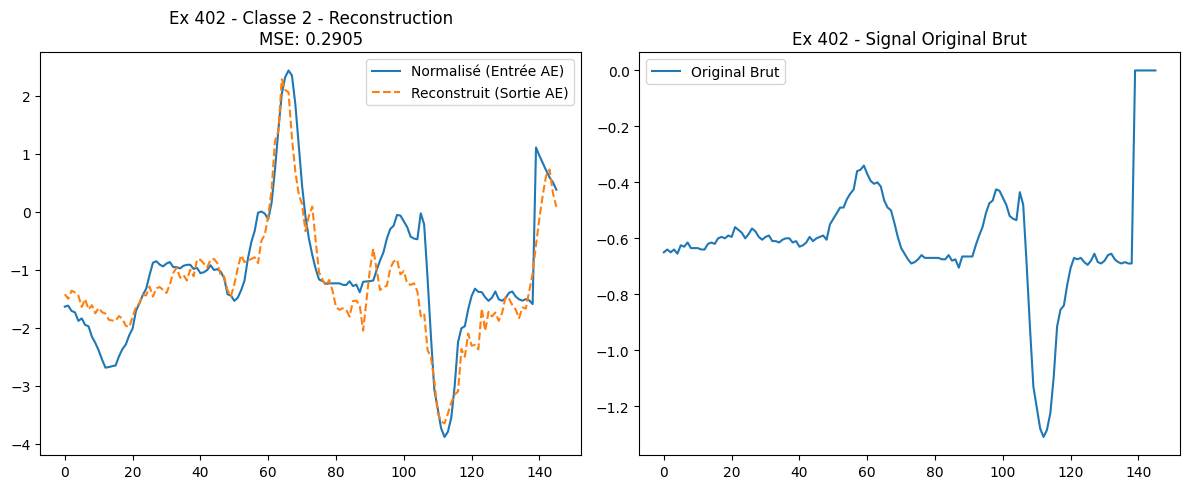

Prédiction: Normal | Réalité: Anomalie
-> FAUX NEGATIF
------------------------------


In [ ]:
print("\n--- Visualisation d'exemples ---")

def plot_example(idx, X_orig, X_norm, reconstructions, mse, y_true, threshold):
    """Affiche un signal original, normalisé, reconstruit et son erreur."""
    plt.figure(figsize=(12, 5))

    # Signal original vs Reconstruit (échelle normalisée)
    plt.subplot(1, 2, 1)
    plt.plot(X_norm[idx], label='Normalisé (Entrée AE)')
    plt.plot(reconstructions[idx], label='Reconstruit (Sortie AE)', linestyle='--')
    plt.title(f"Ex {idx} - Classe {y_true[idx]} - Reconstruction\nMSE: {mse[idx]:.4f}")
    plt.legend()

    # Signal original (pour voir la forme brute)
    plt.subplot(1, 2, 2)
    plt.plot(X_orig[idx], label='Original Brut')
    plt.title(f"Ex {idx} - Signal Original Brut")
    plt.legend()

    plt.tight_layout()
    plt.show()

    is_anomaly_pred = mse[idx] > threshold
    is_anomaly_true = y_true[idx] > 0
    print(f"Prédiction: {'Anomalie' if is_anomaly_pred else 'Normal'} | Réalité: {'Anomalie' if is_anomaly_true else 'Normal'}")
    if is_anomaly_pred != is_anomaly_true:
        print(f"-> {'FAUX POSITIF' if not is_anomaly_true else 'FAUX NEGATIF'}")
    else:
        print(f"-> {'VRAI POSITIF' if is_anomaly_true else 'VRAI NEGATIF'}")
    print("-" * 30)

# Trouver des indices pour chaque cas (si possible)
indices_n = np.where(y_test == 0)[0]
indices_r = np.where(y_test == 1)[0]
indices_v = np.where(y_test == 2)[0]

# Exemple Normal bien classé (Vrai Négatif)
vn_candidates = indices_n[mse_test[indices_n] <= threshold]
if len(vn_candidates) > 0:
    print("Exemple Vrai Négatif (Normal détecté Normal)")
    plot_example(vn_candidates[0], X_test, X_test_normalized, reconstructions_test, mse_test, y_test, threshold)

# Exemple Faux Positif (Normal détecté Anomalie)
fp_candidates = indices_n[mse_test[indices_n] > threshold]
if len(fp_candidates) > 0:
    print("Exemple Faux Positif (Normal détecté Anomalie)")
    plot_example(fp_candidates[0], X_test, X_test_normalized, reconstructions_test, mse_test, y_test, threshold)

# Exemple Anomalie R bien classée (Vrai Positif)
vp_r_candidates = indices_r[mse_test[indices_r] > threshold]
if len(vp_r_candidates) > 0:
    print("Exemple Vrai Positif (Anomalie R détectée)")
    plot_example(vp_r_candidates[0], X_test, X_test_normalized, reconstructions_test, mse_test, y_test, threshold)

# Exemple Faux Négatif R (Anomalie R détectée Normal)
fn_r_candidates = indices_r[mse_test[indices_r] <= threshold]
if len(fn_r_candidates) > 0:
    print("Exemple Faux Négatif (Anomalie R détectée Normal)")
    plot_example(fn_r_candidates[0], X_test, X_test_normalized, reconstructions_test, mse_test, y_test, threshold)

# Exemple Anomalie V bien classée (Vrai Positif)
vp_v_candidates = indices_v[mse_test[indices_v] > threshold]
if len(vp_v_candidates) > 0:
    print("Exemple Vrai Positif (Anomalie V détectée)")
    plot_example(vp_v_candidates[0], X_test, X_test_normalized, reconstructions_test, mse_test, y_test, threshold)

# Exemple Faux Négatif V (Anomalie V détectée Normal)
fn_v_candidates = indices_v[mse_test[indices_v] <= threshold]
if len(fn_v_candidates) > 0:
    print("Exemple Faux Négatif (Anomalie V détectée Normal)")
    plot_example(fn_v_candidates[0], X_test, X_test_normalized, reconstructions_test, mse_test, y_test, threshold)